
# Forward Simulation for Straight Ray Tomography in 2D

Here we module *simpeg.seismic.straight_ray_tomography* to predict arrival
time data for a synthetic velocity/slowness model. In this tutorial, we focus on the following:

    - How to define the survey
    - How to define the forward simulation
    - How to predict arrival time data


## Import Modules




In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from discretize import TensorMesh

from simpeg import maps
from simpeg.seismic import straight_ray_tomography as tomo

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Defining a Tensor Mesh

Here, we create the tensor mesh that will be used to predict arrival time
data.




In [2]:
# dh = 50.0  # cell width
# N = 100  # number of cells in X and Y direction
# hx = [(dh, N)]
# hy = [(dh, N)]
# mesh = TensorMesh([hx, hy], "CC")
dh = 10.0  # cell width
N = 21  # number of cells in X and Y direction
hx = [(dh, N)]
hy = [(dh, N)]
mesh = TensorMesh([hx, hy], "CC")

## Model and Mapping on Tensor Mesh

Here, we create the velocity model that will be used to predict the data. Since
the physical parameter for straight ray tomography is slowness, we must define
a mapping which converts velocity values to slowness values. The model
consists of a lower velocity block within a higher velocity background.




In [6]:
# Define velocity of each unit in m/s
bottom_velocity = 4500.0
middle_velocity = 3000.0
# top_velocity = 1500.0
top_velocity = 3000.0

top_thickness = 45.0
middle_thickness = 50.0

# Define the model. Models in SimPEG are vector arrays.
model = bottom_velocity * np.ones(mesh.nC)

# Create layered model based on y-coordinates
y_coords = mesh.gridCC[:, 1]

# Top layer: y > (top_thickness - mesh.h[1].sum()/2)
ind_top = y_coords > (mesh.h[1].sum()/2 - top_thickness)
model[ind_top] = top_velocity

# # Middle layer: (top_thickness + middle_thickness - mesh.h[1].sum()/2) < y <= (top_thickness - mesh.h[1].sum()/2)
# ind_middle = (y_coords > (mesh.h[1].sum()/2 - top_thickness - middle_thickness)) & (y_coords <= (mesh.h[1].sum()/2 - top_thickness))
# model[ind_middle] = middle_velocity

# Define a mapping from the model (velocity) to the slowness. If your model
# consists of slowness values, you can use *maps.IdentityMap*.
model_mapping = maps.ReciprocalMap()

## Defining the Survey

Here, we define survey that will be used for the forward simulation. The survey
consists of a horizontal line of point receivers at Y = 100 m and a horizontal
line of point sources at Y = -100 m. The shot by each source is measured by
all receivers.




In [7]:
R = 100
x = np.linspace(-R, R, 11)  # 11 sources/receivers across full width

y_receivers = R * np.ones(len(x))   # slightly above surface
y_sources   = -R * np.ones(len(x))   # exactly at surface

# Create coordinate arrays
receiver_locations = np.c_[x, y_receivers]
source_locations   = np.c_[x, y_sources]

# Define receivers and sources for tomography survey
receiver_list = [tomo.Rx(receiver_locations)]
source_list = [tomo.Src(location=source_locations[ii, :],
                        receiver_list=receiver_list)
               for ii in range(len(source_locations))]

survey = tomo.Survey(source_list)

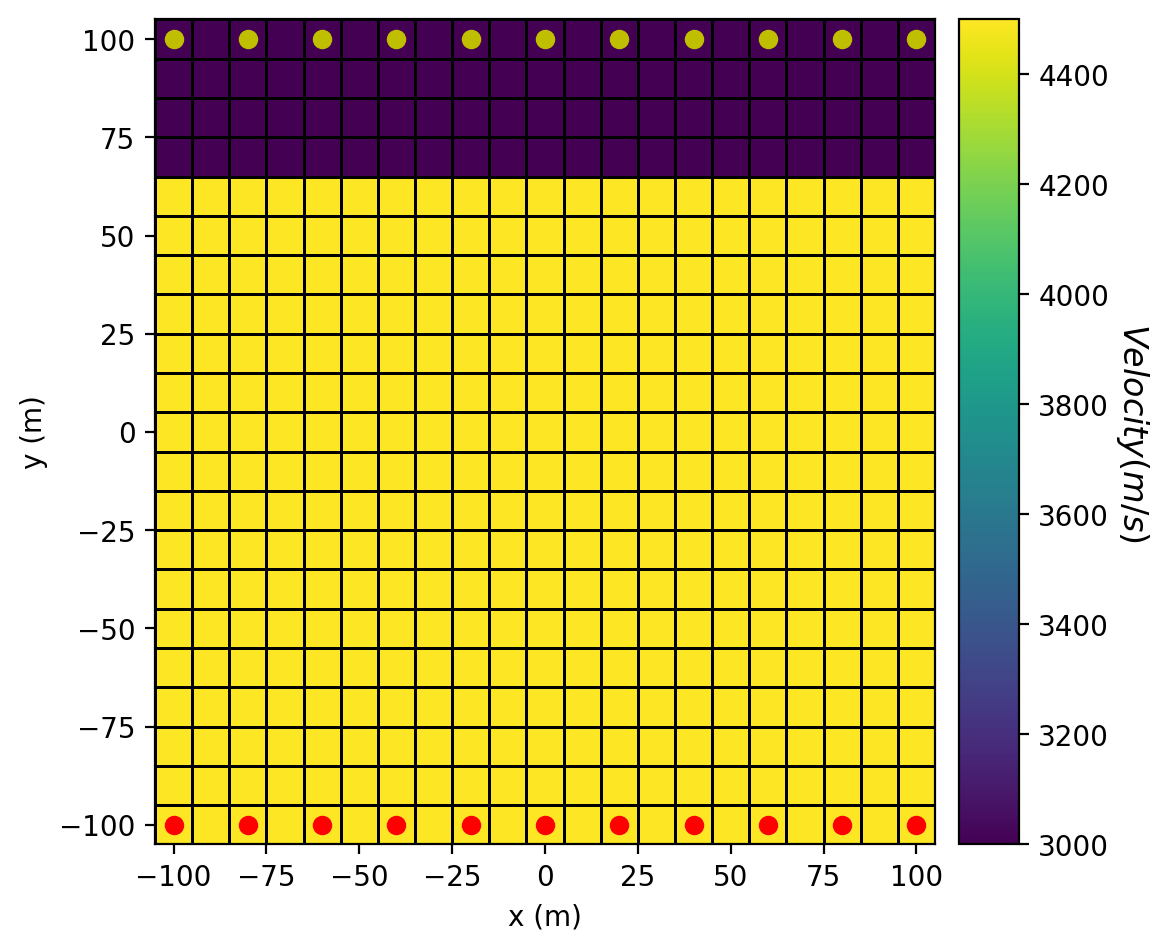

In [8]:
# Plot Velocity Model
fig = plt.figure(figsize=(6, 5.5))

ax1 = fig.add_axes([0.15, 0.15, 0.65, 0.75])
mesh.plot_image(model, ax=ax1, grid=True, pcolor_opts={"cmap": "viridis"})
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
ax1.plot(x, y_sources, "ro")  # source locations
ax1.plot(x, y_receivers, "yo")  # receiver locations

ax2 = fig.add_axes([0.82, 0.15, 0.05, 0.75])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$Velocity (m/s)$", rotation=270, labelpad=15, size=12)

## Simulation: Arrival Time

Here we demonstrate how to predict arrival time data for the 2D straight
ray tomography problem using the 2D Integral formulation.




In [9]:
# Define the forward simulation. To do this we need the mesh, the survey and
# the mapping from the model to the slowness values on the mesh.
simulation = tomo.Simulation(mesh, survey=survey, slownessMap=model_mapping)

# Compute predicted data for some model
dpred = simulation.dpred(model)

## Plotting




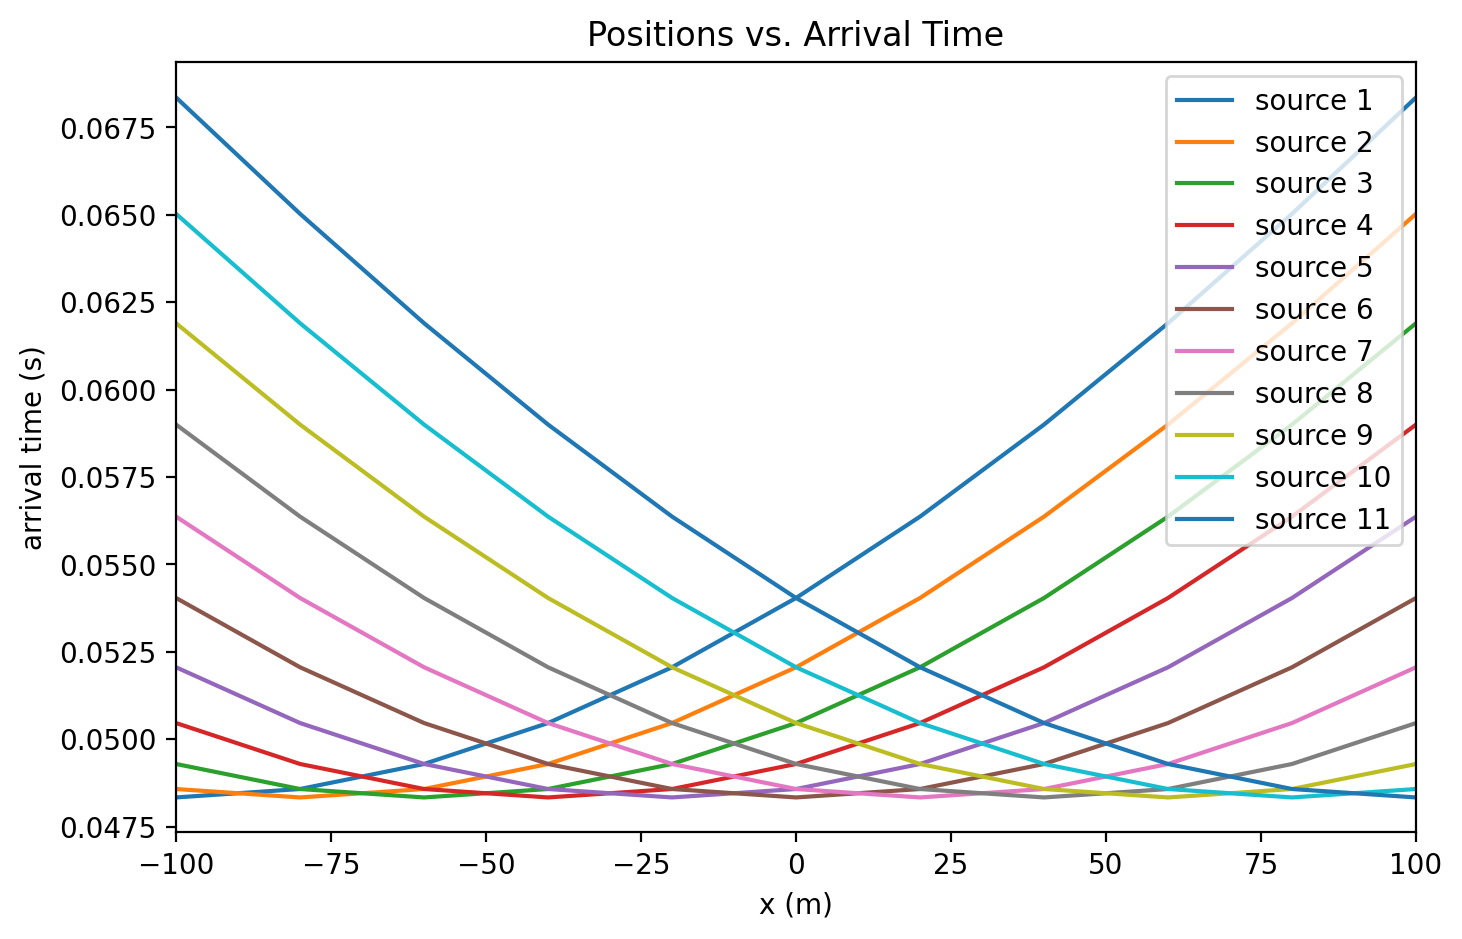

In [10]:
n_source = len(source_list)
n_receiver = len(x)
dpred_plotting = dpred.reshape(n_receiver, n_source)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)
obs_string = []

for ii in range(0, n_source):
    ax.plot(x, dpred_plotting[:, ii])
    obs_string.append("source {}".format(ii + 1))

ax.set_xlim(np.min(x), np.max(x))
ax.set_xlabel("x (m)")
ax.set_ylabel("arrival time (s)")
ax.set_title("Positions vs. Arrival Time")
ax.legend(obs_string, loc="upper right")

## Optional: Exporting Results

Write the data and true model




In [ ]:
dir_path = "../data/"
os.makedirs(dir_path, exist_ok=True)

noise = 0.005 * dpred * np.random.randn(len(dpred))

data_array = np.c_[
    np.kron(x, np.ones(n_receiver)),
    np.kron(y_sources, np.ones(n_receiver)),
    np.kron(np.ones(n_source), x),
    np.kron(np.ones(n_source), y_receivers),
    dpred + noise,
]

fname = dir_path + "tomography2D_data_layer.obs"
np.savetxt(fname, data_array, fmt="%.4e")

output_model = model
fname = dir_path + "true_model_2D_layer.txt"
np.savetxt(fname, output_model, fmt="%.4e")